In [1]:
# Cell 1: Import all required libraries
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_openai import ChatOpenAI
from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from dotenv import load_dotenv
from IPython.display import Image, display
import requests
import sqlite3
import os
import json

In [2]:
load_dotenv(override=True)

True

In [3]:
from dotenv import load_dotenv
import os
import time

load_dotenv()

def send_whatsapp_notification(message: str):
    """Send WhatsApp notification about job application updates"""
    from twilio.rest import Client

    # Get credentials
    account_sid = os.getenv("WHATSAPP_ACCOUNT_SID")
    auth_token = os.getenv("WHATSAPP_AUTH_TOKEN")
    from_number = os.getenv("WHATSAPP_FROM_NUMBER")  # Should be +14155238886
    to_number = "+4915222350056"  

    # Validate credentials
    if not all([account_sid, auth_token, from_number]):
        return "❌ Error: WhatsApp credentials not found in environment variables."

    if not message or not message.strip():
        return "❌ Error: Message content cannot be empty."

    try:
        client = Client(account_sid, auth_token)
        
        # WhatsApp message length limit
        MAX_LENGTH = 1500  # Conservative limit
        
        if len(message) <= MAX_LENGTH:
            # Send as single message
            twilio_message = client.messages.create(
                from_=f'whatsapp:{from_number}',
                body=f"🚀 Job Assistant Update:\n\n{message}",
                to=f'whatsapp:{to_number}'
            )
            return f"✅ WhatsApp message sent successfully! SID: {twilio_message.sid}"
        else:
            # Split into multiple messages
            chunks = [message[i:i + MAX_LENGTH] for i in range(0, len(message), MAX_LENGTH)]
            sids = []
            
            for i, chunk in enumerate(chunks, 1):
                content = f"🚀 Job Assistant (Part {i}/{len(chunks)}):\n\n{chunk}"
                twilio_message = client.messages.create(
                    from_=f'whatsapp:{from_number}',
                    body=content,
                    to=f'whatsapp:{to_number}'
                )
                sids.append(twilio_message.sid)
                
                # Rate limiting
                if i < len(chunks):
                    time.sleep(2)
            
            return f"✅ WhatsApp message sent in {len(chunks)} parts! SIDs: {', '.join(sids)}"
            
    except Exception as e:
        return f"❌ Failed to send WhatsApp message: {str(e)}"

In [4]:
def search_jobs(query: str):
    """Search for job listings using Google Search"""
    try:
        # Using Google search to find job listings
        search_query = f"{query} jobs site:linkedin.com OR site:indeed.com OR site:glassdoor.com"
        serper = GoogleSerperAPIWrapper()
        results = serper.run(search_query)
        return results
    except Exception as e:
        return f"Job search failed: {str(e)}"

In [5]:
def research_company(company_name: str):
    """Research company information for interview preparation"""
    try:
        serper = GoogleSerperAPIWrapper()
        research_query = f"{company_name} company culture recent news funding"
        results = serper.run(research_query)
        return results
    except Exception as e:
        return f"Company research failed: {str(e)}"

In [6]:
def get_salary_info(job_title: str, location: str = ""):
    """Get salary information for a specific job title and location"""
    try:
        serper = GoogleSerperAPIWrapper()
        salary_query = f"{job_title} salary {location} glassdoor levels.fyi"
        results = serper.run(salary_query)
        return results
    except Exception as e:
        return f"Salary research failed: {str(e)}"

In [7]:
tool_whatsapp = Tool(
    name="send_whatsapp_notification",
    func=send_whatsapp_notification,
    description="Send WhatsApp notification about important job updates or reminders"
)

tool_job_search = Tool(
    name="search_jobs",
    func=search_jobs,
    description="Search for job listings based on role, skills, or company"
)

tool_company_research = Tool(
    name="research_company",
    func=research_company,
    description="Research company information, culture, and recent news for interview prep"
)

tool_salary_research = Tool(
    name="get_salary_info",
    func=get_salary_info,
    description="Get salary information for specific job titles and locations"
)

In [8]:
tools = [tool_whatsapp, tool_job_search, tool_company_research, tool_salary_research]


In [9]:
class JobAssistantState(TypedDict):
    """State structure for our Job Application Assistant"""
    messages: Annotated[list, add_messages]
    # Could add more fields like:
    # current_applications: list
    # interview_schedule: list
    

In [10]:
graph_builder = StateGraph(JobAssistantState)

In [11]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
llm_with_tools = llm.bind_tools(tools)

In [12]:
def job_assistant(state: JobAssistantState):
    """
    Main assistant node that processes user requests and decides on actions
    """
    # Add system prompt for job assistance context
    system_message = {
        "role": "system",
        "content": """You are a helpful Job Application Assistant. You can:

        1. Search for job opportunities
        2. Research companies for interview preparation
        3. Find salary information
        4. Send WhatsApp notifications for important updates

        Always be encouraging and professional. When you find important information
        or complete a task, consider sending a WhatsApp notification to keep the user updated.

        For job searches, be specific about what you found.
        For company research, focus on culture, recent news, and interview tips.
        For salary research, provide ranges and mention sources.
        """
    }

    # Combine system message with conversation history
    messages_with_system = [system_message] + state["messages"]

    # Get response from LLM
    response = llm_with_tools.invoke(messages_with_system)

    return {"messages": [response]}

In [13]:
graph_builder.add_node("job_assistant", job_assistant)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [14]:
# Start with the assistant
graph_builder.add_edge(START, "job_assistant")

# Conditional edge: if tools needed, go to tools node, otherwise end
graph_builder.add_conditional_edges(
    "job_assistant",
    tools_condition,
    {
        "tools": "tools",
        "__end__": END
    }
)

# After using tools, always return to assistant
graph_builder.add_edge("tools", "job_assistant")

In [15]:
db_path = "job_assistant_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

In [16]:
job_graph = graph_builder.compile(checkpointer=memory)

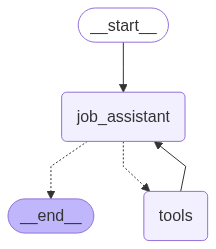

In [17]:
display(Image(job_graph.get_graph().draw_mermaid_png()))

In [18]:
print("Testing WhatsApp notification...")
result = tool_whatsapp.invoke("Job Assistant is now active and ready to help!")
print(result)

Testing WhatsApp notification...
✅ WhatsApp message sent successfully! SID: SMf0ce95b75534d1a2a242b73695df0dca


In [19]:
def chat_with_job_assistant(user_input: str, thread_id: str = "default_user"):
    """
    Main chat function for interacting with the job assistant
    """
    config = {"configurable": {"thread_id": thread_id}}

    # Invoke the graph with user input
    result = job_graph.invoke(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config
    )

    # Return the last assistant message
    return result["messages"][-1].content

In [20]:
if __name__ == "__main__":

    # Example 1: Job Search
    print("=== Example 1: Job Search ===")
    response1 = chat_with_job_assistant(
        "Find me Python developer jobs in San Francisco",
        thread_id="user_john"
    )
    print(response1)

    print("\n" + "="*50 + "\n")

    # Example 2: Company Research
    print("=== Example 2: Company Research ===")
    response2 = chat_with_job_assistant(
        "Research Google as a company for my upcoming interview",
        thread_id="user_john"
    )
    print(response2)

    print("\n" + "="*50 + "\n")

    # Example 3: Salary Research
    print("=== Example 3: Salary Research ===")
    response3 = chat_with_job_assistant(
        "What's the salary range for Senior Software Engineer in Seattle?",
        thread_id="user_john"
    )
    print(response3)

    print("\n" + "="*50 + "\n")

    # Example 4: Memory Test
    print("=== Example 4: Memory Test ===")
    response4 = chat_with_job_assistant(
        "Send me a WhatsApp reminder about the companies we discussed",
        thread_id="user_john"  # Same thread - should remember Google
    )
    print(response4)

=== Example 1: Job Search ===
I found a significant number of Python developer job opportunities in San Francisco! Here are the details:

### Job Listings
- **Total Listings**: Approximately **1,500 Python developer jobs** available in the San Francisco Bay Area.
- **Job Types**: Positions include:
  - Python Developer
  - Front End Developer
  - Software Trainer
  - Backend Python Developer
  - Data Scientist
  - Machine Learning Engineer

### Salary Ranges
- **Entry-Level Positions**: Typically range from **$30 to $35** per hour.
- **Full Stack Engineer**: Estimated between **$120,000 - $180,000** annually.
- **Software Engineer (Backend)**: Estimated between **$143,640 - $197,640** annually.

These opportunities can be found on platforms like Indeed.com, and new listings are added daily.

If you're interested in applying or need help with your application materials, such as a resume or cover letter, just let me know! Would you like me to send this information as a WhatsApp notificat

In [21]:
def view_conversation_history(thread_id: str):
    """View the complete conversation history for a thread"""
    config = {"configurable": {"thread_id": thread_id}}

    # Get current state
    current_state = job_graph.get_state(config)
    print(f"Current conversation for thread '{thread_id}':")
    print("="*50)

    for message in current_state.values["messages"]:
        role = message.get("role", "unknown")
        content = message.get("content", "")
        print(f"{role.upper()}: {content[:100]}...")
        print("-" * 30)

In [22]:

import gradio as gr

def gradio_chat(message, history, thread_id):
    response = chat_with_job_assistant(message, thread_id)
    return response

# Create Gradio interface
demo = gr.ChatInterface(
    fn=gradio_chat,
    title="🚀 Job Application Assistant",
    description="AI assistant for job searching, company research, and application tracking with WhatsApp notifications!",
    additional_inputs=[
        gr.Textbox(value="default_user", label="Thread ID (for separate conversations)")
    ]
)

# Launch the interface
demo.launch(share=True)


/Users/bharathkumarreddygorla/Desktop/my-agentic-ai-examples/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/bharathkumarreddygorla/Desktop/my-agentic-ai-examples/.venv/lib/python3.13/site-packages/gradio/chat_interface.py:339: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://648430521803919e65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
